In [1]:
# /path: pet_segmentation.ipynb

import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Load Oxford Pets dataset with the correct version
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

C:\Users\carin\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                             | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 100%|█████████████████████| 1/1 [00:00<00:00, 82.57 url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|                           | 0/19173078 [00:00<?, ? MiB/s]

Dl Size...: 100%|████| 19173078/19173078 [00:00<00:00, 1004970229.29 MiB/s]

Dl Size...: 100%|█████| 19173078/19173078 [00:00<00:00, 710843434.52 MiB/s]

Dl Size...: 100%|█████| 19173078/19173078 [00:00<00:00, 639458947.25 MiB/s]

Dl Size...:   2%|    | 19173078/811092049 [00:00<00:01, 581304884.69 MiB/s]

Dl Size...: 100%|█| 811092049/811092049 [00:00<00:00, 22541074756.59 MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]
Generating splits...:   0%|                     | 0/2 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
Generating train examples...: 729 examples [00:01

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\carin\tensorflow_datasets\oxford_iiit_pet\4.0.0. Subsequent calls will reuse this data.


In [3]:
# Normalize images and labels
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.int32) - 1
    return input_image, input_mask

In [4]:
# Resize and normalize
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    return normalize(input_image, input_mask)

In [6]:
# Prepare datasets
auto = tf.data.AUTOTUNE
train = dataset['train'].map(load_image, num_parallel_calls=auto)
test = dataset['test'].map(load_image, num_parallel_calls=auto)

train_dataset = train.cache().shuffle(1000).batch(64).repeat().prefetch(buffer_size=auto)
test_dataset = test.batch(64)

In [12]:
# Define encoder as a function for modular notebook cells
def build_encoder(inputs):
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)
    return c1, c2, p2

In [16]:
# Define bottleneck as a function
def build_bottleneck(p2):
    bn = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    bn = layers.Conv2D(128, 3, activation='relu', padding='same')(bn)
    return bn

In [22]:
# Define decoder as a function
def build_decoder(bn, c2, c1):
    u1 = layers.UpSampling2D()(bn)
    concat1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat1)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D()(c3)
    concat2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat2)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    return c4

In [23]:
# Define full model
def get_model():
    inputs = tf.keras.Input(shape=(128, 128, 3))

    c1, c2, p2 = build_encoder(inputs)
    bn = build_bottleneck(p2)
    dec_out = build_decoder(bn, c2, c1)

    outputs = layers.Conv2D(3, 1, activation='softmax')(dec_out)

    return models.Model(inputs, outputs)

In [24]:
# Instantiate and compile model
model = get_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Model architecture summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer        │ (None, 128, 128, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_2 (Conv2D)  │ (None, 128, 128, │       896 │ input_layer[0][… │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_3 (Conv2D)  │ (None, 128, 128, │     9,248 │ conv2d_2[0][0]   │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ max_pooling2d      │ (None, 64, 64,   │         0 │ conv2d_3[0][0]   │
│ (MaxPooling2D)     │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_4 (Conv2D)  │ (None, 64, 64,   │    18,496 │ max_pooling2d[0… │
│                    │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_5 (Conv2D)  │ (None, 64, 64,   │    36,928 │ conv2d_4[0][0]   │
│                    │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ max_pooling2d_1    │ (None, 32, 32,   │         0 │ conv2d_5[0][0]   │
│ (MaxPooling2D)     │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_6 (Conv2D)  │ (None, 32, 32,   │    73,856 │ max_pooling2d_1… │
│                    │ 128)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_7 (Conv2D)  │ (None, 32, 32,   │   147,584 │ conv2d_6[0][0]   │
│                    │ 128)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ up_sampling2d_2    │ (None, 64, 64,   │         0 │ conv2d_7[0][0]   │
│ (UpSampling2D)     │ 128)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ concatenate        │ (None, 64, 64,   │         0 │ up_sampling2d_2… │
│ (Concatenate)      │ 192)             │           │ conv2d_5[0][0]   │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_8 (Conv2D)  │ (None, 64, 64,   │   110,656 │ concatenate[0][… │
│                    │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_9 (Conv2D)  │ (None, 64, 64,   │    36,928 │ conv2d_8[0][0]   │
│                    │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ up_sampling2d_3    │ (None, 128, 128, │         0 │ conv2d_9[0][0]   │
│ (UpSampling2D)     │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ concatenate_1      │ (None, 128, 128, │         0 │ up_sampling2d_3… │
│ (Concatenate)      │ 96)              │           │ conv2d_3[0][0]   │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_10 (Conv2D) │ (None, 128, 128, │    27,680 │ concatenate_1[0… │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_11 (Conv2D) │ (None, 128, 128, │     9,248 │ conv2d_10[0][0]  │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2d_12 (Conv2D) │ (None, 128, 128, │        99 │ conv

 Total params: 471,619 (1.80 MB)

 Trainable params: 471,619 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Parameter count explanation (Q3)
def explain_params():
    layer_params = [
        ("Conv2D(3->32)", (3*3*3 + 1) * 32),
        ("Conv2D(32->32)", (3*3*32 + 1) * 32),
        ("Conv2D(32->64)", (3*3*32 + 1) * 64),
        ("Conv2D(64->64)", (3*3*64 + 1) * 64),
        ("Conv2D(64->128)", (3*3*64 + 1) * 128),
        ("Conv2D(128->128)", (3*3*128 + 1) * 128),
        ("Conv2D(192->64)", (3*3*192 + 1) * 64),
        ("Conv2D(64->64)", (3*3*64 + 1) * 64),
        ("Conv2D(96->32)", (3*3*96 + 1) * 32),
        ("Conv2D(32->32)", (3*3*32 + 1) * 32),
        ("Conv2D(32->3)", (1*1*32 + 1) * 3),
    ]
    total = sum([p[1] for p in layer_params])
    print("Layer-wise parameter breakdown:")
    for name, val in layer_params:
        print(f"{name:<20} → {val:,} params")
    print("\nTotal parameters (Q3 answer):", total)

explain_params()


Layer-wise parameter breakdown:
Conv2D(3->32)        → 896 params
Conv2D(32->32)       → 9,248 params
Conv2D(32->64)       → 18,496 params
Conv2D(64->64)       → 36,928 params
Conv2D(64->128)      → 73,856 params
Conv2D(128->128)     → 147,584 params
Conv2D(192->64)      → 110,656 params
Conv2D(64->64)       → 36,928 params
Conv2D(96->32)       → 27,680 params
Conv2D(32->32)       → 9,248 params
Conv2D(32->3)        → 99 params

Total parameters (Q3 answer): 471619


In [27]:
# Train model
EPOCHS = 5
STEPS_PER_EPOCH = 100

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_dataset)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.5916 - loss: 0.9010 - val_accuracy: 0.6977 - val_loss: 0.7140
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.7099 - loss: 0.6850 - val_accuracy: 0.7619 - val_loss: 0.5861
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.7478 - loss: 0.6083 - val_accuracy: 0.7788 - val_loss: 0.5555
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.7768 - loss: 0.5508 - val_accuracy: 0.7731 - val_loss: 0.5609
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.7858 - loss: 0.5318 - val_accuracy: 0.7953 - val_loss: 0.5086


In [35]:
# Visualize prediction
def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        img = display_list[i]
        if img.shape[-1] == 1:
            img = tf.squeeze(img, axis=-1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    return tf.argmax(pred_mask, axis=-1)[..., tf.newaxis]

def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        image = tf.expand_dims(image, axis=0)
        pred_mask = model.predict(image)
        display([image[0], mask, create_mask(pred_mask)[0]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


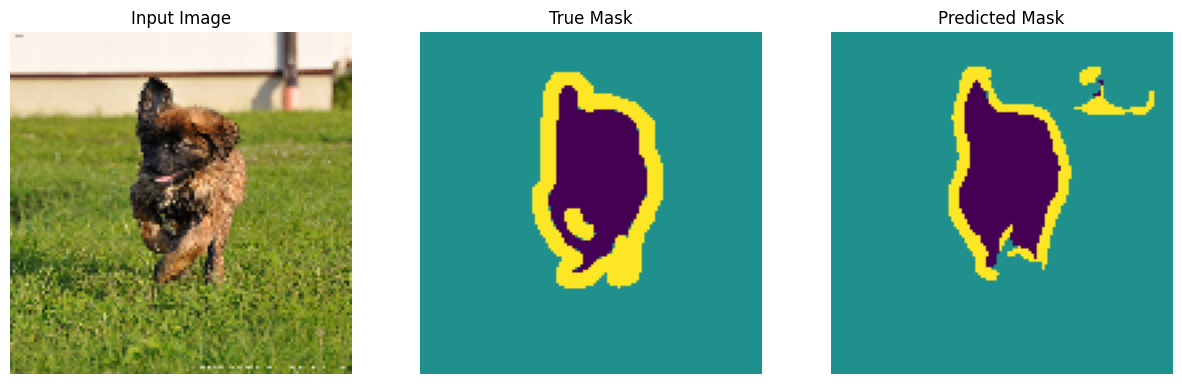

In [36]:
# Show predictions
show_predictions(test)

In [37]:
# Total parameter count
print("Total parameters (from Keras API):", model.count_params())

Total parameters (from Keras API): 471619
